# <font color="DarkBlue">Emojify!</font>

In [1]:
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline

## <font color="IndianRed">Baseline model: Emojifier-V1</font>

### <font color="Indigo">Dataset EMOJISET</font>

Let's start by building a simple baseline classifier. 

You have a tiny dataset (X, Y) where:
- X contains 127 sentences (strings).
- Y contains an integer label between 0 and 4 corresponding to an emoji for each sentence.

EMOJISET is a classification problem with 5 classes.

In [2]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

In [3]:
maxLen = len(max(X_train, key=len).split())

Run the following cell to print sentences from X_train and corresponding labels from Y_train. 

In [4]:
for idx in range(10):
    print(f'{X_train[idx]:40} {label_to_emoji(Y_train[idx]):2}')

never talk to me again                   😞 
I am proud of your achievements          😄 
It is the worst day in my life           😞 
Miss you so much                         ❤️
food is life                             🍴 
I love you mum                           ❤️
Stop saying bullshit                     😞 
congratulations on your acceptance       😄 
The assignment is too long               😞 
I want to go play                        ⚾ 


### <font color='Indigo'>Overview of the Emojifier-V1</font>


#### Inputs and outputs
* The input of the model is a string corresponding to a sentence (e.g. "I love you). 
* The output will be a probability vector of shape (1,5), (there are 5 emojis to choose from).
* The (1,5) probability vector is passed to an argmax layer, which extracts the index of the emoji with the highest probability.

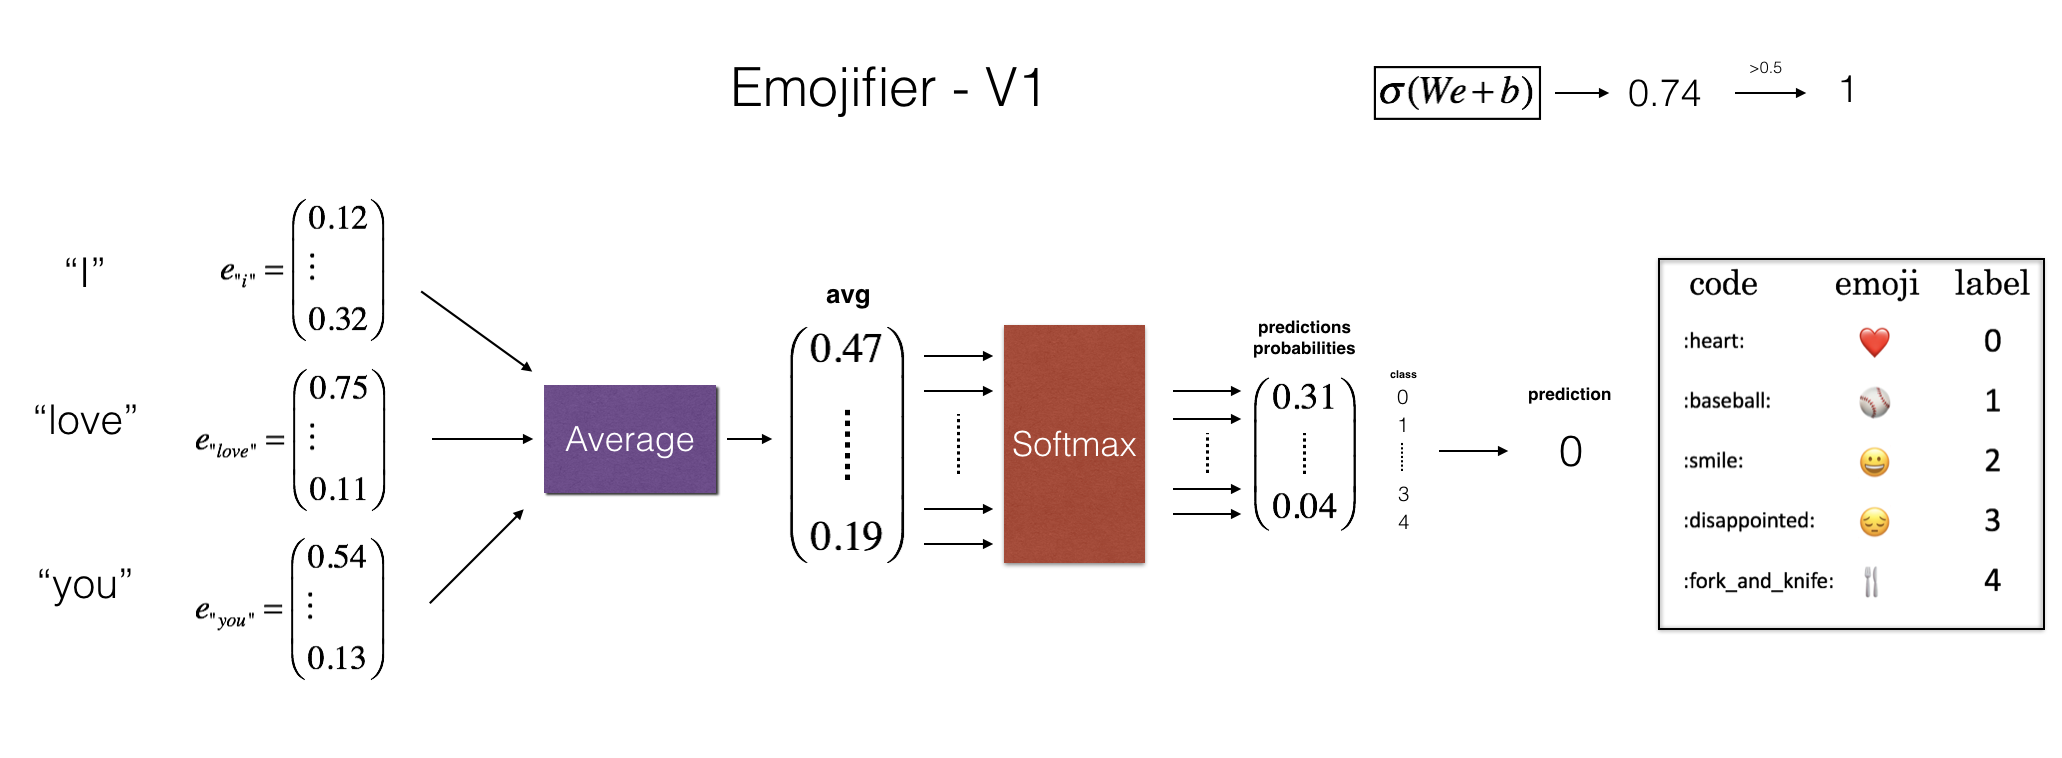

In [5]:
Image('images/image_1.png', width=900, height=800)

#### One-hot encoding
To get our labels into a format suitable for training a softmax classifier, lets convert $Y$ from its current shape  $(m, 1)$ into a "one-hot representation" $(m, 5)$. Each row is a one-hot vector giving the label of one example. Here, `Y_oh` stands for "Y-one-hot" in the variable names `Y_oh_train` and `Y_oh_test`: 

In [6]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [7]:
idx = 50
print(f"Sentence '{X_train[50]}' -> Label index {Y_train[idx]} -> emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} -> one-hot encoded:{Y_oh_train[idx]}")

Sentence 'I missed you' -> Label index 0 -> emoji ❤️
Label index 0 -> one-hot encoded:[ 1.  0.  0.  0.  0.]


### <font color="indigo">Implementing Emojifier-V1</font>

* Convert each word in the input sentence into their word vector representations.
* Then take an average of the word vectors. 
* Similar to the previous exercise, we will use pre-trained 50-dimensional GloVe embeddings. 

Run the following cell to load the `word_to_vec_map`, which contains all the vector representations.

In [8]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('../../readonly/glove.6B.50d.txt')

Loaded:
- `word_to_index`: dictionary mapping from words to their indices in the vocabulary 
- `index_to_word`: dictionary mapping from indices to words in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation.

In [9]:
word = "cucumber"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


**Exercise**: Implement `sentence_to_avg()`. You will need to carry out two steps:
1. Convert every sentence to lower-case, then split the sentence into a list of words. 
    * `X.lower()` and `X.split()` might be useful. 
2. For each word in the sentence, access its GloVe representation. Then take the average of all of these word vectors.
    
    
#### Additional Hints
* When creating the `avg` array of zeros, you'll want it to be a vector of the same shape as the other word vectors in the `word_to_vec_map`.  
    * You can choose a word that exists in the `word_to_vec_map` and access its `.shape` field.
    * Be careful not to hard code the word that you access.
    * You can use any word vectors retrieved from the input `sentence` to find the shape of a word vector.

In [10]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    
    # Step 1: Split sentence into list of lower case words
    words = [i.lower() for i in sentence.split()]

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros((50,))
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    total = 0
    for w in words:
        total += word_to_vec_map[w]
    avg = total / len(words) 
    return avg

In [11]:
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = \n", avg)

avg = 
 [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]


#### Model

You now have all the pieces to finish implementing the `model()` function. 
After using `sentence_to_avg()` you need to:
* Pass the average through forward propagation
* Compute the cost
* Backpropagate to update the softmax parameters

**Exercise**: Implement the `model()` function. 

* The equations you need to implement in the forward pass and to compute the cross-entropy cost are below:
* The variable $Y_{oh}$ ("Y one hot") is the one-hot encoding of the output labels. 

$$ z^{(i)} = W . avg^{(i)} + b$$

$$ a^{(i)} = softmax(z^{(i)})$$

$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k)$$

**Note** It is possible to come up with a more efficient vectorized implementation. For now, let's use nested for loops to better understand the algorithm, and for easier debugging. We provided the function `softmax()`, which was imported earlier.

In [12]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    np.random.seed(1)

    # Define number of training examples
    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
            
            
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W, avg) + b
            a = softmax(z)

            # Compute cost
            cost = cost = -np.sum(np.dot(Y_oh[i], np.log(a)))
        
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in emo_utils.py

    return pred, W, b

In [13]:
print(X_train.shape, Y_train.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(str(X_train[0]) + "of type:" + str(type(X_train)))


Y = np.asarray([5,0,0,5, 4, 4, 4, 6, 6, 4, 1, 1, 5, 6, 6, 3, 6, 3, 4, 4])
X = np.asarray(['I am going to the bar tonight', 'I love you', 'miss you my dear',
 'Lets go party and drinks','Congrats on the new job','Congratulations',
 'I am so happy for you', 'Why are you feeling bad', 'What is wrong with you',
 'You totally deserve this prize', 'Let us go play football',
 'Are you down for football this afternoon', 'Work hard play harder',
 'It is suprising how people can be dumb sometimes',
 'I am very disappointed','It is the best day in my life',
 'I think I will end up alone','My life is so boring','Good job',
 'Great so awesome'])

print(X.shape, Y.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)

(132,) (132,)
(132, 5)
never talk to me againof type:<class 'numpy.ndarray'>
(20,) (20,)
(132, 5)


In [14]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
#print(pred)

Epoch: 0 --- cost = 1.95204988128
Accuracy: 0.348484848485
Epoch: 100 --- cost = 0.0797181872601
Accuracy: 0.931818181818
Epoch: 200 --- cost = 0.0445636924368
Accuracy: 0.954545454545
Epoch: 300 --- cost = 0.0343226737879
Accuracy: 0.969696969697


### <font color="Indigo">Examining test set performance</font>

* `predict()` used here is defined in emo_util.spy.

In [15]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.977272727273
Test set:
Accuracy: 0.857142857143


In [16]:
X_my_sentences = np.array(["i adore you", \
                           "i love you", \
                           "funny lol", \
                           "lets play with a ball", \
                           "food is ready", \
                           "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])
pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.833333333333

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


(56,)
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


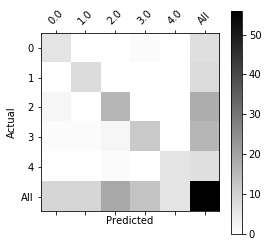

In [17]:
print(Y_test.shape)
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

## <font color="IndianRed">Emojifier-V2: Using LSTMs in Keras</font>

In [18]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

Using TensorFlow backend.


### <font color="indigo">Overview of the Emojifier-v2 model</font>

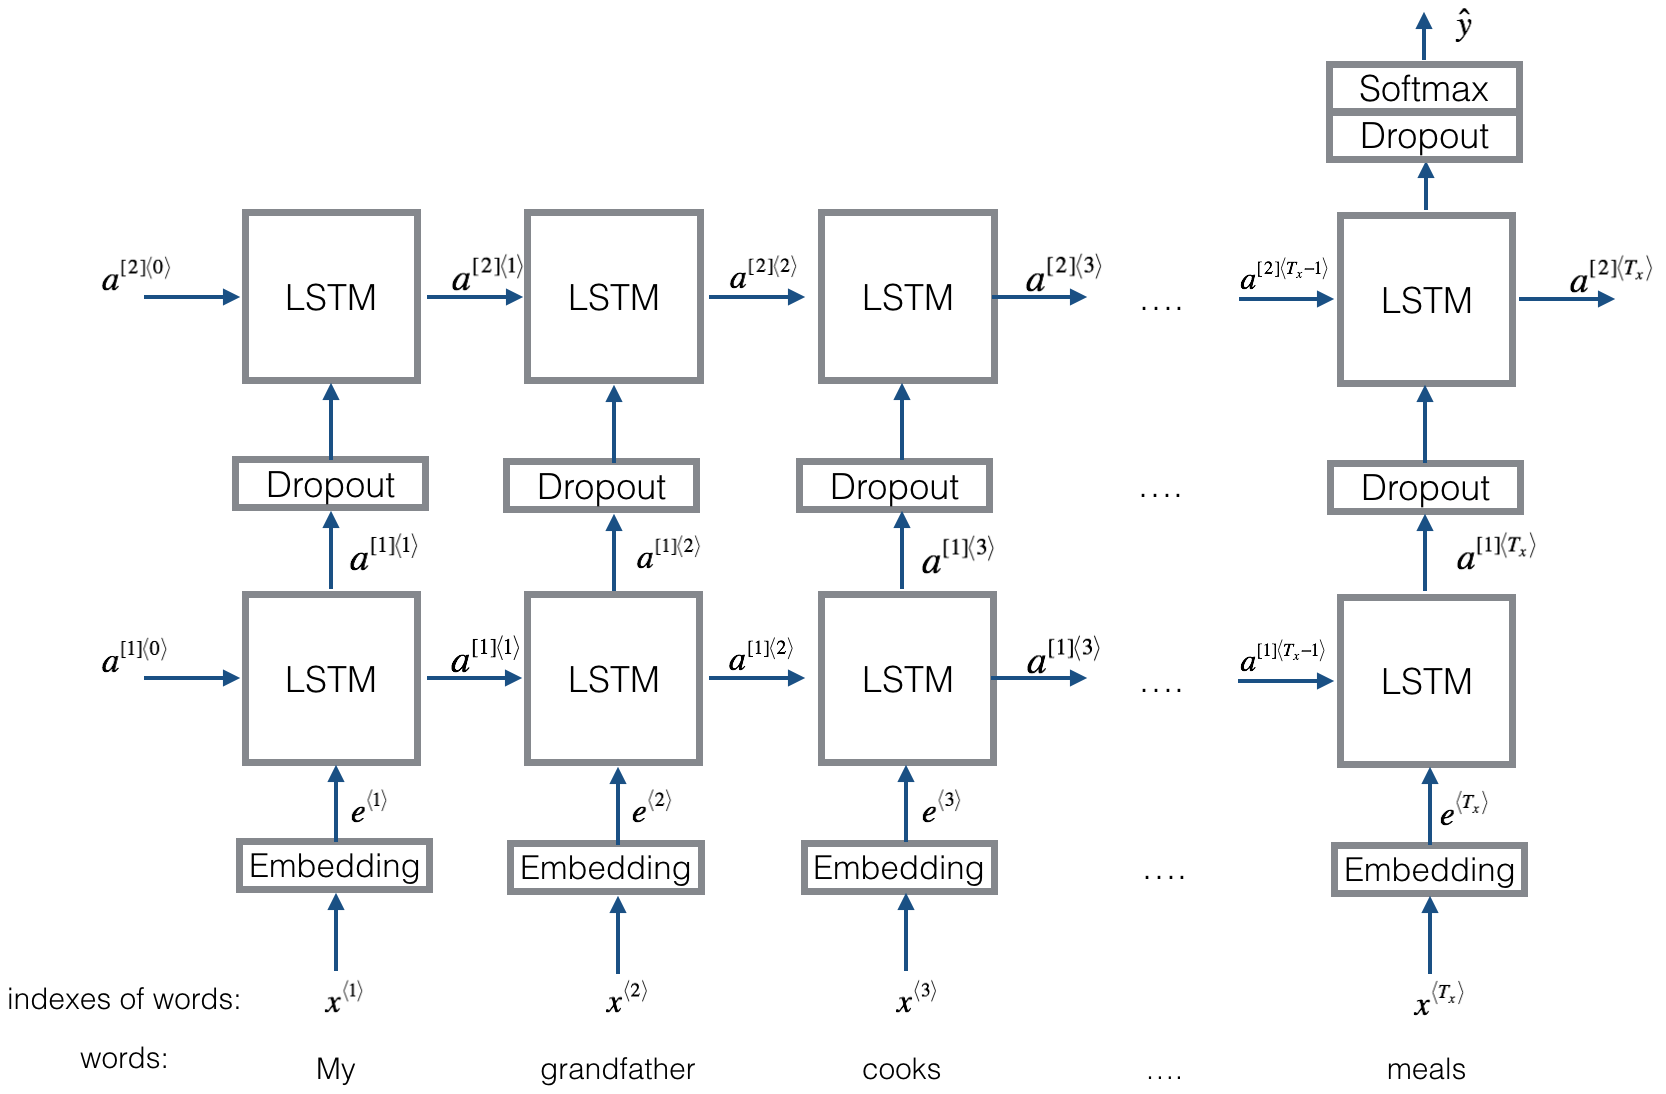

In [19]:
Image("images/emojifier-v2.png", width=600, height=600)

### <font color="indigo">Keras and mini-batching</font>

* In this exercise, we want to train Keras using mini-batches. 
* However, most deep learning frameworks require that all sequences in the same mini-batch have the same length. This is what allows vectorization to work: If you had a 3-word sentence and a 4-word sentence, then the computations needed for them are different (one takes 3 steps of an LSTM, one takes 4 steps) so it's just not possible to do them both at the same time.
    
#### Padding handles sequences of varying length
* The common solution to handling sequences of different length is to use padding.
    * Set a maximum sequence length
    * Pad all sequences to have the same length. 
    
#### Example of padding
* Given a maximum sequence length of 20, we could pad every sentence with "0"s so that each input sentence is of length 20. Thus, the sentence "I love you" would be represented as $(e_{I}, e_{love}, e_{you}, \vec{0}, \vec{0}, \ldots, \vec{0})$. 
* Any sentences longer than 20 words would have to be truncated. One way to choose the maximum sequence length is to just pick the length of the longest sentence in the training set.

### <font color="indigo">The Embedding layer</font>

* In Keras, the embedding matrix is represented as a `layer`.
* The embedding matrix maps word indices to embedding vectors.
    * The word indices are positive integers.
    * The embedding vectors are dense vectors of fixed size.
    * When we say a vector is "dense", in this context, it means that most of the values are non-zero.  As a counter-example, a one-hot encoded vector is not "dense."
* The embedding matrix can be derived in two ways:
    * Training a model to derive the embeddings from scratch. 
    * Using a pretrained embedding
    
#### Using and updating pre-trained embeddings
* In this part, you will learn how to create an [Embedding()](https://keras.io/layers/embeddings/) layer in Keras
* You will initialize the Embedding layer with the GloVe 50-dimensional vectors. 
* In the code below, we'll show you how Keras allows you to either train or leave fixed this layer.  
* Because our training set is quite small, we will leave the GloVe embeddings fixed instead of updating them.

#### Inputs and outputs to the embedding layer

* The `Embedding()` layer's input is an integer matrix of size `(batch size, max input length)`. 
    * This input corresponds to sentences converted into lists of indices (integers).
    * The largest integer (the highest word index) in the input should be no larger than the vocabulary size.
* The embedding layer outputs an array of shape (batch size, max input length, dimension of word vectors).

* The figure shows the propagation of two example sentences through the embedding layer. 
    * Both examples have been zero-padded to a length of `max_len=5`.
    * The word embeddings are 50 units in length.
    * The final dimension of the representation is  `(2,max_len,50)`.

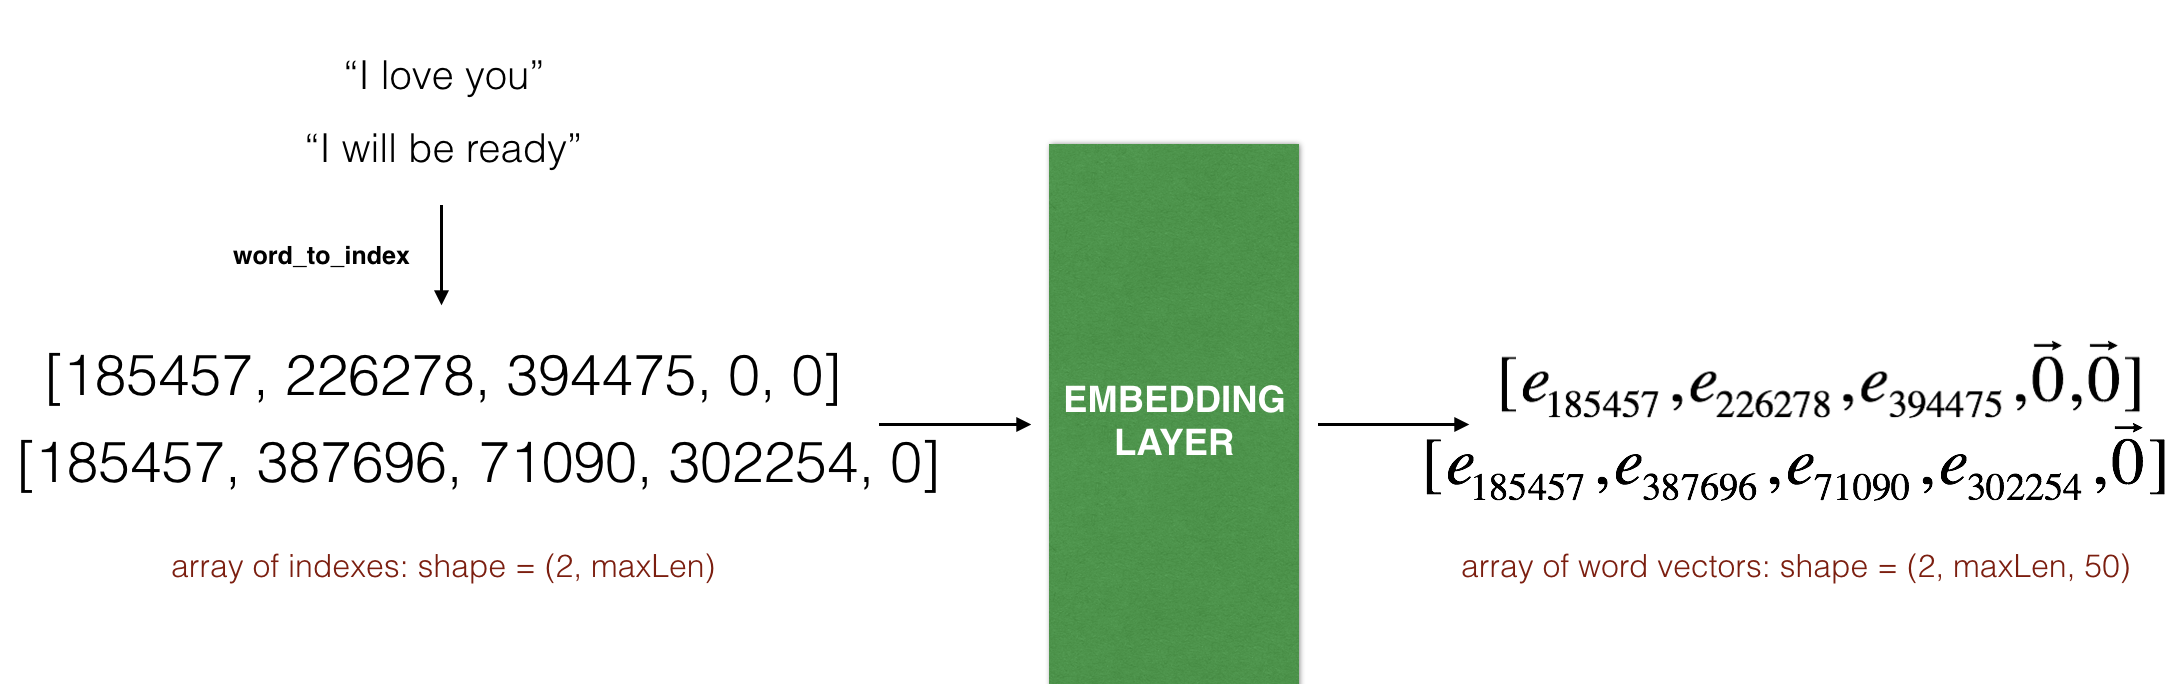

In [20]:
Image("images/embedding1.png", height=700, width=800)

#### Prepare the input sentences
**Exercise**: 
* Implement `sentences_to_indices`, which processes an array of sentences (X) and returns inputs to the embedding layer:

* Convert each training sentences into a list of indices (the indices correspond to each word in the sentence).  Zero-pad all these lists so that their length is the length of the longest sentence.

In [21]:
for idx, val in enumerate(["I", "like", "learning"]):
    print(idx,val)

0 I
1 like
2 learning


In [22]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]          # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):  
        
        # Convert the ith training sentence in lower case and split is into words.
        sentence_words = X[i].lower().split()
        
        
        j = 0
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            j += 1
    
    return X_indices

In [23]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[ 155345.  225122.       0.       0.       0.]
 [ 220930.  286375.   69714.       0.       0.]
 [ 151204.  192973.  302254.  151349.  394475.]]


#### Build embedding layer

Let's build the `Embedding()` layer in Keras, using pre-trained word vectors. The embedding layer takes as input a list of word indices. `sentences_to_indices()` creates these word indices. The embedding layer will return the word embeddings for a sentence. 

**Exercise**: Implement `pretrained_embedding_layer()` with these steps:
1. Initialize the embedding matrix as a numpy array of zeros.
    * The embedding matrix has a row for each unique word in the vocabulary.
        * There is one additional row to handle "unknown" words.
        * So vocab_len is the number of unique words plus one.
    * Each row will store the vector representation of one word. 
        * For example, one row may be 50 positions long if using GloVe word vectors.
    * In the code below, `emb_dim` represents the length of a word embedding.
2. Fill in each row of the embedding matrix with the vector representation of a word
    * Each word in `word_to_index` is a string.
    * word_to_vec_map is a dictionary where the keys are strings and the values are the word vectors.
3. Define the Keras embedding layer. 
    * Use [Embedding()](https://keras.io/layers/embeddings/). 
    * The input dimension is equal to the vocabulary length (number of unique words plus one).
    * The output dimension is equal to the number of positions in a word embedding.
    * Make this layer's embeddings fixed.
        * If you were to set `trainable = True`, then it will allow the optimization algorithm to modify the values of the word embeddings.
        * In this case, we don't want the model to modify the word embeddings.
4. Set the embedding weights to be equal to the embedding matrix. 

In [24]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors
    
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(vocab_len, emb_dim)

    # Step 4 (already done for you; please do not modify)
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [25]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


## <font color="IndianRed">Building the Emojifier-V2</font>

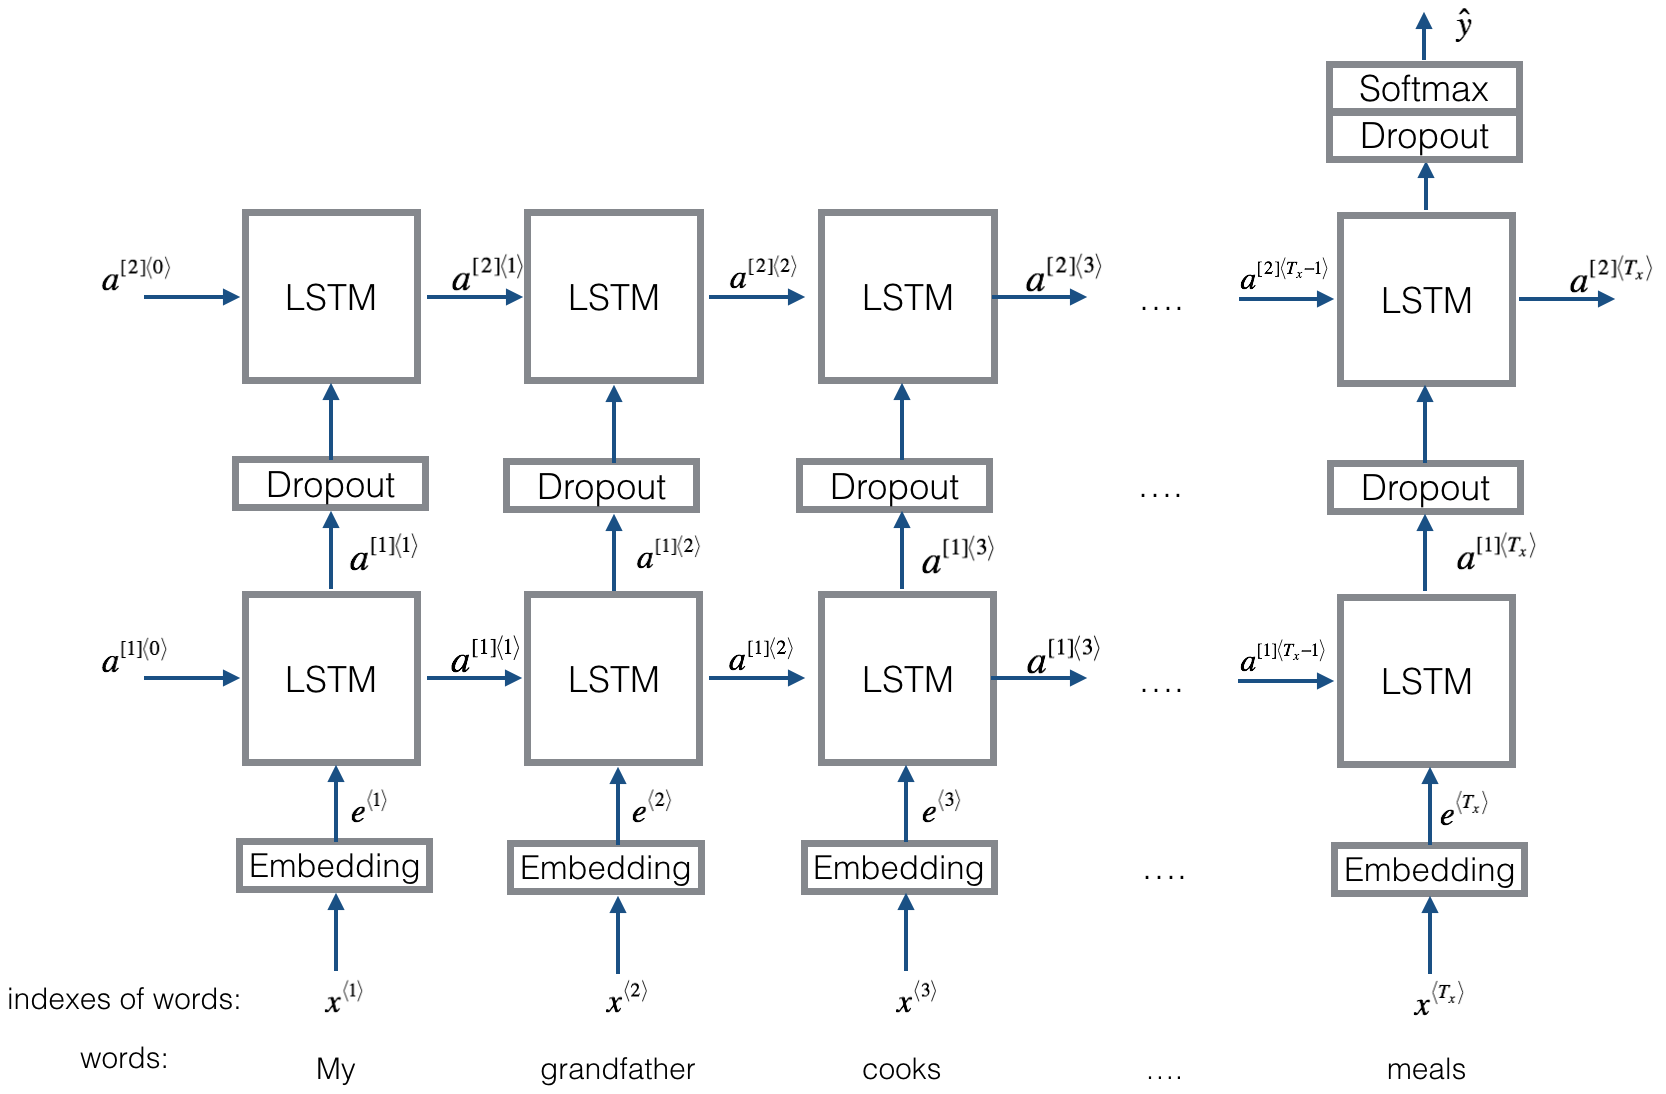

In [26]:
Image("images/emojifier-v2.png", width=800, height=600)

**Exercise:** Implement `Emojify_V2()`, which builds a Keras graph
* The model takes as input an array of sentences of shape (`m`, `max_len`, ) defined by `input_shape`. 
* The model outputs a softmax probability vector of shape (`m`, `C = 5`). 

* You may need to use the following Keras layers:
    * [Input()](https://keras.io/layers/core/#input)
        * Set the `shape` and `dtype` parameters.
        * The inputs are integers, so you can specify the data type as a string, 'int32'.
    * [LSTM()](https://keras.io/layers/recurrent/#lstm)
        * Set the `units` and `return_sequences` parameters.
    * [Dropout()](https://keras.io/layers/core/#dropout)
        * Set the `rate` parameter.
    * [Dense()](https://keras.io/layers/core/#dense)
        * Set the `units`, 
        * Note that `Dense()` has an `activation` parameter.  For the purposes of passing the autograder, please do not set the activation within `Dense()`.  Use the separate `Activation` layer to do so.
    * [Activation()](https://keras.io/activations/).
        * You can pass in the activation of your choice as a lowercase string.
    * [Model](https://keras.io/models/model/)
        Set `inputs` and `outputs`.


#### Additional Hints
* Remember that these Keras layers return an object, and you will feed in the outputs of the previous layer as the input arguments to that object.  The returned object can be created and called in the same line.

```Python
# How to use Keras layers in two lines of code
dense_object = Dense(units = ...)
X = dense_object(inputs)

# How to use Keras layers in one line of code
X = Dense(units = ...)(inputs)
```

* The `embedding_layer` that is returned by `pretrained_embedding_layer` is a layer object that can be called as a function, passing in a single argument (sentence indices).

* Here is some sample code in case you're stuck
```Python
raw_inputs = Input(shape=(maxLen,), dtype='int32')
preprocessed_inputs = ... # some pre-processing
X = LSTM(units = ..., return_sequences= ...)(processed_inputs)
X = Dropout(rate = ..., )(X)
...
X = Dense(units = ...)(X)
X = Activation(...)(X)
model = Model(inputs=..., outputs=...)
...
```

In [27]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units = 128, return_sequences= True)(embeddings)
    
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5)(X)
    
    # Propagate X through another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units = 128, return_sequences= False)(X)
    
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5)(X)
    
    # Propagate X through a Dense layer with 5 units
    X = Dense(units = 5)(X)
    
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs= sentence_indices, outputs= X)
    return model

In [28]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
__________

Compile your model using `categorical_crossentropy` loss, `adam` optimizer and `['accuracy']` metrics:

In [29]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

Fit the Keras model on `X_train_indices` and `Y_train_oh`. We will use `epochs = 50` and `batch_size = 32`.

In [31]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
132/132 [==============================] - 4s - loss: 1.6105 - acc: 0.1667     
Epoch 2/50
132/132 [==============================] - 4s - loss: 1.5372 - acc: 0.3106     
Epoch 3/50
132/132 [==============================] - 3s - loss: 1.5043 - acc: 0.3030     
Epoch 4/50
132/132 [==============================] - 3s - loss: 1.4408 - acc: 0.3561     
Epoch 5/50
132/132 [==============================] - 4s - loss: 1.3490 - acc: 0.4394     
Epoch 6/50
132/132 [==============================] - 3s - loss: 1.2231 - acc: 0.5379     
Epoch 7/50
132/132 [==============================] - 3s - loss: 1.1462 - acc: 0.4848     
Epoch 8/50
132/132 [==============================] - 3s - loss: 1.0064 - acc: 0.6212     
Epoch 9/50
132/132 [==============================] - 3s - loss: 0.8005 - acc: 0.7424     
Epoch 10/50
132/132 [==============================] - 3s - loss: 0.7207 - acc: 0.7576     
Epoch 11/50
132/132 [==============================] - 4s - loss: 0.5822 - acc: 0.7879   

In [32]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

32/56 [================>.............] - ETA: 0s
Test accuracy =  0.821428562914


In [33]:
# This code allows you to see the mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: ' \ 
              + X_test[i] + label_to_emoji(num).strip())

Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:😞 prediction: work is horrible	😄
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😞 prediction: she is a bully	❤️
Expected emoji:😄 prediction: will you be my valentine	❤️
Expected emoji:🍴 prediction: See you at the restaurant	😄
Expected emoji:😞 prediction: go away	⚾
Expected emoji:🍴 prediction: I did not have breakfast 😄


Write your own sentence below. 

In [34]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(['not feeling happy'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

not feeling happy 😞
